# Support Vector Machines(SVM) Classifier


In this notebook we will be creating a Linear SVM for plotting a decision boundary on a linear seperable data from scratch. We will also be using the SVC package from Sklearn to plot a non-linear decision boundary.

In [1]:
import os
from IPython.display import Image
if 'google.colab' in str(get_ipython()):
    root_dir = "/gdrive/MyDrive"
    lab_dir  = "SVM_Classifier"
  
    working_dir = os.path.join(root_dir, lab_dir)
    from google.colab import drive
    drive.mount('/gdrive',force_remount=True)
  
    if("SVM_classifier.ipynb" in os.listdir(working_dir)):
        print("Successfully Loaded Lab Directory")
        os.chdir(working_dir)
    else:
        print("Failed to Load the Directory from "+working_dir+".\nPlease check the given 'lab_dir' is correct and rerun.")
    

Mounted at /gdrive
Successfully Loaded Lab Directory


In [2]:
import numpy as np
import os
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from utils import *
import tensorflow as tf
from sklearn.datasets import make_blobs,make_moons
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
import imageio
from IPython.display import Image
import sys

In [3]:
np.random.seed(0)
output_dir = "./output"
os.makedirs(output_dir,exist_ok=True)

---
**Part-1: Creating Linear SVM from scratch** 
---

 * We will make a Linear SVM classifier using gradient descent and the Hinge Loss. The loss function and its gradient computation are used as it is from theory. We have a linearly seperable dataset and create a boundary with the help of the support vectors which will classify the data points into 4 classes.

In [4]:
class LinearSVM():
    def __init__(self,x_dim=2,n_class=3,delta=1,lamda=0.1,lr=1e-3,batch_size=128,n_iter=2000,log_freq=10):
        self.x_dim      = x_dim          # Feature dimension
        self.n_class    = n_class        # No. of Classes
        self.delta      = delta          # Margin by which the scores of correct classes should be higher than incorrect ones
        self.lamda      = lamda          # The regularization hyperparameter
        self.lr         = lr             # The learning rate
        self.batch_size = batch_size     # Batch Size
        self.n_iter     = n_iter         # No. of training iterations
        self.log_freq   = log_freq       # Frequency of logging the progress
        self.history    = {
                        "loss":{"Training":[],"Validation":[],"Testing":[]},
                        "accuracy":{"Training":[],"Validation":[],"Testing":[]},
                        "weights":[],
                        "decision_surface":[]
                        }
        self.W          = self.initialize_weight()
        self.dataset    = self.load_dataset()
        self.train_dataset, self.validation_dataset, self.test_dataset = self.split_dataset(self.dataset)
        
    def split_dataset(self,dataset):
        X_train, X_test, y_train, y_test = train_test_split(dataset[0],dataset[1],test_size=0.33,random_state=23)
        X_test, X_val, y_test, y_val     = train_test_split(X_test,y_test, test_size=0.33,random_state=23)
        return (X_train,y_train),(X_val,y_val),(X_test,y_test)

    def train(self):
        X,Y = self.train_dataset
        n_data = X.shape[0]
        for iteration in range(1,self.n_iter+1):
            batch_idx = np.random.choice(range(0,n_data),self.batch_size)
            x_batch   = X[batch_idx]
            y_batch   = Y[batch_idx]
            loss      = self.loss(x_batch,y_batch)
            gradient  = self.gradient(x_batch,y_batch)
            y_pred    = self.predict(x_batch)
            accuracy  = self.accuracy(y_pred,y_batch)
            self.update_weight(gradient)
            
            if(iteration%self.log_freq==0):
                self.log("Training",iteration,loss,accuracy)
                validation_loss,validation_acc = self.validate()
                self.log("Validation",iteration,validation_loss,validation_acc)
                self.history["weights"].append(self.W)
                self.history["decision_surface"].append(self.visualize_weights())

        test_loss,test_acc = self.test()
        self.log("Testing",iteration,validation_loss,validation_acc)
        
    def validate(self):
        X,Y = self.validation_dataset
        n_data = X.shape[0]
        batch_idx = np.random.choice(range(0,n_data),self.batch_size)
        x_batch   = X[batch_idx]
        y_batch   = Y[batch_idx]
        loss      = self.loss(x_batch,y_batch)
        y_pred    = self.predict(x_batch)
        accuracy  = self.accuracy(y_pred,y_batch)
        return loss,accuracy

    def test(self):
        X,Y = self.test_dataset
        n_data = X.shape[0]
        accuracies = []
        losses     = []
        for iteration in range(0,n_data//self.batch_size):
            batch_idx = range(iteration*self.batch_size,(iteration+1)*self.batch_size)
            x_batch   = X[batch_idx]
            y_batch   = Y[batch_idx]
            loss      = self.loss(x_batch,y_batch)
            y_pred    = self.predict(x_batch)
            accuracy  = self.accuracy(y_pred,y_batch)
            accuracies.append(accuracy)
            losses.append(loss)
        return np.mean(losses), np.mean(accuracies)    
        
    def log(self,mode,iteration,loss,accuracy):
        print("--"*40)
        print("{:10s} | Iter : {:5f}| Loss : {:5f}| Accuracy: {:5f}".format(mode,iteration,loss,accuracy))
        self.history["loss"][mode].append(loss)
        self.history["accuracy"][mode].append(accuracy)

    def check_gradients(self):
        x,y = self.train_dataset
        x = x[:128]
        y = y[:128]    
        curr_W = self.W
        def eval_grad_loss(W):
            self.W = W
            return self.loss(x,y)
        numeric_gradient  = eval_numerical_gradient(eval_grad_loss,self.initialize_weight())
        analytic_gradient = self.gradient(x,y)
        numeric_gradient  = numeric_gradient.reshape([-1,])
        analytic_gradient = analytic_gradient.reshape([-1,])
        relative_error = np.average(np.abs(numeric_gradient - analytic_gradient) / numeric_gradient, axis=0)
        print(" Numerical & Analytic Gradient Relative Error : ",relative_error)
        self.W = curr_W

    
    def initialize_weight(self):
        """
        Function to initialize the parameters (W) of the model.
        Input   : None
        Returns : A numpy array of dimension equal to the weight dimension (feature_dim x #classes)
                  The values can be drawn from any distribution of your choice - normal distribution,
                  uniform distribution, etc. Try initialization using different distributions and pick the
                  best performing.
        
        """
        W = np.random.normal(0, 1, size=(self.x_dim, self.n_class))
        
        return W
    
    def load_dataset(self):
        """
        Function to load the dataset.
        Input   : None
        Returns : Data samples (X) and their corresponding labels (y) 
        """
        X,y =  make_blobs(100000,cluster_std=0.40,centers=[(-2,0),(2,0),(0,2),(0,-2)])
        return X,y 

    def visualize_weights(self):
        """
        Function to visualize the learned decision surface.
        Input   : None
        Returns : The plotted decision surface
        """
        X,y = self.train_dataset
        X = X[:5000]
        y = y[:5000]
        fig, ax = plt.subplots()
        title = ('Decision surface')
        X0, X1 = X[:, 0], X[:, 1]
        xx, yy = make_meshgrid(X0, X1)
        plot_contours(ax, self, xx, yy, cmap=plt.cm.Spectral, alpha=0.6)
        ax.scatter(X0, X1, c=y, cmap=plt.cm.Spectral, s=30, edgecolors='k')
        ax.set_ylabel('Y Axis')
        ax.set_xlabel('X Axis')
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(title)
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return image_from_plot

    
    def loss(self,X,y):
        """
        Function to compute the loss. (Refer to the notes for loss definition)
        Input   : Batch of data samples (X) and its labels (y)
        Returns : The SVM loss on the inputed data batch. (scalar)
        
        """
        n_data = X.shape[0]
        scores = X.dot(self.W)
        scores_y = scores[np.arange(scores.shape[0]), y] 
        margins = np.maximum(0, scores - np.matrix(scores_y).T + self.delta)
        margins[np.arange(n_data),y] = 0
        loss = np.mean(np.sum(margins, axis=1))
        loss += 0.5*self.lamda*np.sum(np.dot(self.W, self.W.T))
        
        return loss
    
    def gradient(self,X,y):
        """
        Function to compute the gradient. (Refer to the notes for gradient computation help)
        Input   : Batch of data samples (X) and its labels (y)
        Returns : The gradient w.r.t the weights (W) for the loss on the inputed data batch. (dim = dim of W)
        
        """
        n_data = X.shape[0]
        dW = np.zeros(self.W.shape) 
        scores = X.dot(self.W)
        scores_y = scores[np.arange(scores.shape[0]), y] 
        margins = np.maximum(0, scores - np.matrix(scores_y).T + self.delta)
        margins[np.arange(n_data),y] = 0
        b = margins
        b[margins>0] = 1
        row_sum = np.sum(b, axis=1)
        b[np.arange(n_data), y] = -row_sum.T
        dW = np.dot(X.T, b)
        dW /= n_data
        dW += self.lamda*self.W
        
        return dW
    

    def update_weight(self,gradient):
        """
        Function to update the weights using the gradient update rule : W = W - learning_rate x gradients.
        Input   : Gradients
        Returns : Nothing.
                  Use the gradient inputed to update the weight matrix (The weight matrix and learning rate are a member variable of the class. See __init__ of LinearSVM for all member variables)
        
        """
        self.W = self.W - lr*gradient
    

    def predict(self,X):
        """
        Function to predict the target class for the inputed batch of samples the gradient( hint: class having highest score as assigned by the SVM)
        Input   : Batch of data samples (X) (- dim: batch_size x feature_dim)
        Returns : The predicted labels      (- dim: batch_size)
        
        """
        scores = X.dot(self.W)
        y_pred = scores.argmax(axis=1)

        return np.array(y_pred)
    
    def accuracy(self,Y_pred,Y_true):
        return accuracy_score(Y_pred,Y_true)


We check the working of the above code using the below block.

In [5]:
toy_classifier = LinearSVM(n_class=4,n_iter=50,log_freq=50,delta=10)
X,Y       = toy_classifier.train_dataset
x_batch   = X[:5]
y_batch   = Y[:5]

print("\n==>Checking Working of Initialize Weight Function")
W      = toy_classifier.initialize_weight()
print("----- Running Successfull: Weight Dimensionn : ",W.shape) 

print("\n==>Checking Working of Loss Function")
loss      = toy_classifier.loss(x_batch,y_batch)
print("----- Running Successfull: Loss Value : ",loss)


print("\n==>Checking Working of Gradient Function")
gradient      = toy_classifier.gradient(x_batch,y_batch)
if(gradient.shape == toy_classifier.W.shape):
    print("----- Running Successfull: Gradient Dim : ",gradient.shape)
else:
    print("----- Error : Gradient Dim Mismatch. Dim of Gradient Provided :  ",gradient.shape," Weight Dim : ",toy_classifier.W.shape)
toy_classifier.check_gradients()

print("\n==>Checking Working of Predict Function")
y_pred = toy_classifier.predict(x_batch)
if(y_pred.shape == y_batch.shape):
    print("----- Running Successfull: y_pred : ",y_pred, "y_true : ",y_batch)
else:
    print("----- Error: Shape Mismatch - y_pred : ",y_pred, "y_true : ",y_batch)


==>Checking Working of Initialize Weight Function
----- Running Successfull: Weight Dimensionn :  (2, 4)

==>Checking Working of Loss Function
----- Running Successfull: Loss Value :  30.92416122337736

==>Checking Working of Gradient Function
----- Running Successfull: Gradient Dim :  (2, 4)
 Numerical & Analytic Gradient Relative Error :  [[ 0.04192608 -0.01646645 -1.4481036  -0.08044957 -0.50416634 -0.30446797
  -0.04639539  0.07547205]]

==>Checking Working of Predict Function
----- Running Successfull: y_pred :  [2 2 1 1 1] y_true :  [0 0 0 0 3]


----
**Training And Tuning**

----
Changing and tuning of the hyperparameter values to achieve a very high validation accuracy ~ 99%.


In [6]:
delta     = 10
lamda     = 0.1
lr        = 5e-3
batch_size= 2
n_iter    = 5000
log_freq  = 100

toy_classifier = LinearSVM(x_dim=2,n_class=4,delta=delta,lamda=lamda,lr=lr,batch_size=batch_size,n_iter=n_iter,log_freq=log_freq)
toy_classifier.train()
imageio.mimsave('{}/svm_toy.gif'.format(output_dir), toy_classifier.history["decision_surface"])
save(toy_classifier,directory=output_dir)

print("==>Gradient Check:\n")
toy_classifier.check_gradients()

print("\n==>Visualization of Decision Surface Over Training Iterations\n")
with open('{}/svm_toy.gif'.format(output_dir),'rb') as f:
    display(Image(data=f.read()))

Output hidden; open in https://colab.research.google.com to view.

---
**Part-2: Nonlinear SVM Using the Sklearn Package** (30 Points)
---

 * In the first part we implemented a Linear SVM using gradient descent. However, not all datasets are linearly separable. The wide popularity of SVM is due its ability learn complex non linear decision boundaries using kernels. However, gradient computation becomes hard while using kernels. Hence we will use the predefined SVM Classifier from the sklearn package (SVC) which uses the constrained quadratic optimization method (using lagrangian multipliers).

 * We will work with a non-linearly separable 2D toy dataset consisting of 2 Classes.
 

In [12]:
import numpy as np
import os
import pickle 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.datasets import make_moons,make_circles
from utils import *
import matplotlib.pyplot as plt

In [13]:
class NonLinearSVM():
    def __init__(self,C=1e-4,kernel="linear",degree=1):
        self.model      = self.build_model(C=C,kernel=kernel,degree=degree)
        self.dataset    = self.load_dataset()
        self.train_dataset, self.validation_dataset, self.test_dataset = self.split_dataset(self.dataset)
        
    def split_dataset(self,dataset):
        X_train, X_test, y_train, y_test = train_test_split(dataset[0],dataset[1],test_size=0.33,random_state=23)
        X_test, X_val, y_test, y_val     = train_test_split(X_test,y_test, test_size=0.33,random_state=23)
        return (X_train,y_train),(X_val,y_val),(X_test,y_test)

    def train(self):
        X,Y    = self.train_dataset
        self.model.fit(X,Y)
        train_accuracy = self.model.score(X,Y)
        val_accuracy   = self.validate()
        print("Training Accuracy : {} | Validation Accuracy : {} \n".format(train_accuracy,val_accuracy))
        
        print("\n==>Decision Surface Visualization\n")
        self.decision_surface = self.visualize()

    def validate(self):
        X,Y = self.validation_dataset
        return self.model.score(X,Y)

    def test(self):
        X,Y = self.test_dataset
        return self.model.score(X,Y)

    def build_model(self,C=1e-4,kernel="linear",degree=1):
        """
        Function to build the sklearn SVM model using the given hyperparameters 
        
        Input   : Hyperparameters C, kernel and degree
                    Refer to the SVC class documentation from sklearn to identify the utility and range of 
                    values for these hyperparameters
                    
        Returns : An Instance of the SVM Classifier from sklearn instantiated with the given hyperparameters
        
        """
        model = SVC(C=C, kernel=kernel, degree=degree)
        
        return model

    def load_dataset(self):
        n_samples = 1000
        de_linearize = lambda X: np.cos( np.pi*X) + np.sin(  0.2*np.pi * X )
        x1 = np.sort(np.random.rand(n_samples)) * 2
        x2 = de_linearize(x1) + np.random.randn(n_samples) * 0.1
        X1 = np.vstack([x1,x2]).T
        Y1 = np.zeros((n_samples)) 
        x2 = -1*(de_linearize(x1) + np.random.randn(n_samples) * 0.1)
        X2 = np.vstack([x1-0.9*np.ones_like(x1),x2+2*np.ones_like(x2)]).T
        Y2 = np.ones((n_samples)) 
        X  = np.append(X1,X2,axis=0)
        Y  = np.append(Y1,Y2,axis=0)
        return X,Y
    
    def predict(self,x):
        return self.model.predict(x)

    def visualize(self):
        """
        Function to visualize the SVM decision boundary 
        
        Input   : None  
        Returns : An image frame for the generated plot
        """
        
        X,y = self.train_dataset
        X = X[:5000]
        y = y[:5000]
        fig, ax = plt.subplots(figsize=(8,6))
        
        # fit the model on the given data
        mod = self.model
        mod.fit(X, y)
        
        # plot the given data
        scat = plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.bwr)
        legend1 = ax.legend(*scat.legend_elements(num=1), loc="upper left", title="Class - ")
        ax.add_artist(legend1)    
        
        # create grid to evaluate model
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xx = np.linspace(xlim[0], xlim[1], 30)
        yy = np.linspace(ylim[0], ylim[1], 30)
        YY, XX = np.meshgrid(yy, xx)

        # shape data
        xy = np.vstack([XX.ravel(), YY.ravel()]).T
        
        # get the decision boundary based on the model
        P = mod.decision_function(xy).reshape(XX.shape)
        
        # plot decision boundary
        ax.contour(XX, YY, P, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors=['black'])

        # plot support vectors
        ax.scatter(mod.support_vectors_[:, 0], mod.support_vectors_[:, 1], s=50, lw=1, facecolors='None', edgecolors='k')
    
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.show()
        plt.close()
        return image_from_plot

    

We check the working of the above code using the below block.


==>Checking Working of Build Model Function
----- Running Successfull

==>Checking Working of Visualize Weight Function


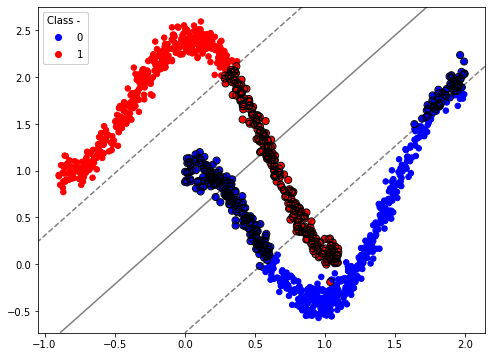

In [14]:
nonlinear_classifier = NonLinearSVM()
X,Y       = nonlinear_classifier.train_dataset
x_batch   = X[:5]
y_batch   = Y[:5]

print("\n==>Checking Working of Build Model Function")
nonlinear_classifier.model = nonlinear_classifier.build_model(C=1,kernel="linear",degree=1)
nonlinear_classifier.model.fit(x_batch,y_batch)
print("----- Running Successfull") 

print("\n==>Checking Working of Visualize Weight Function")
image_frame = nonlinear_classifier.visualize()

----
**Training And Tuning**

----
Here we change and Tune the provided hyperparameter values below till you achieve a very high validation accuracy ~ 99%.

(10 Points)

Training Accuracy : 1.0 | Validation Accuracy : 1.0 


==>Decision Surface Visualization



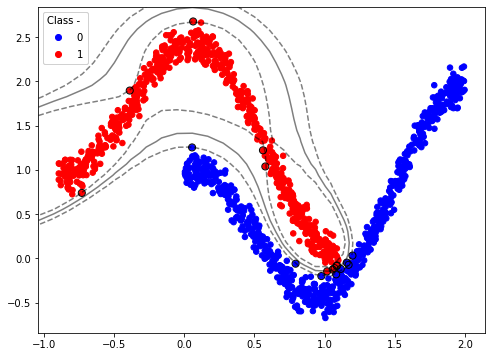

In [15]:
C      = 1e3
kernel = "rbf"
degree = 1


nonlinear_classifier = NonLinearSVM(C=C,kernel=kernel,degree=degree)
nonlinear_classifier.train()
imageio.imwrite('{}/svm_nonlinear.png'.format(output_dir), nonlinear_classifier.decision_surface)
save(nonlinear_classifier,directory=output_dir)
